# Exercise: Build a Movie Recommendation System
Based on the Colab notebook [Recommendation Systems Colab](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems)     



Uses [MovieLens 100K movie ratings](https://grouplens.org/datasets/movielens/). 100,000 ratings from 1000 users on 1700 movies. Released 4/1998.   


# Imports

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython import display
import sklearn
import sklearn.manifold
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

# Load Data

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('ml-100k.zip', 'r')
zip_ref.extractall()
print(str(zip_ref.read('ml-100k/u.info')))

In [3]:
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols

movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Make ids start at 0
users["user_id"] = users["user_id"].apply(lambda x: int(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: int(x-1))
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: int(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: int(x-1))
# Add year
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned
genre_occurences = movies[genre_cols].sum().to_dict()

# Add two cols to movies
# all_genres: all the active genres of the movie
# genre: randomly sampled genre from the active genres
def mark_genres(moveis, genres):
    def get_random_genre(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return np.random.choice(active)
    def get_all_genres(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return '-'.join(active)
    
    movies['genre'] = [get_random_genre(gs) for gs in movies.loc[:, genres].to_numpy()]
    movies['all_genres'] = [get_all_genres(gs) for gs in movies.loc[:, genres].to_numpy()]
    
mark_genres(movies, genre_cols)

# Create one merged DataFrame containing all data (rating, movie, user)
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,...,0,0,0,1997,Adventure,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,...,0,0,0,1996,Romance,Comedy-Romance,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,...,0,0,0,1996,Comedy,Comedy,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,...,0,0,0,1994,Drama,Comedy-Drama,49,M,writer,55105


# Preliminaries
Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.

## Sparse Representation of the Rating Matrix

The rating matrix could be very large and, in general, most of the entries are unobserved, since a given user will only rate a small subset of movies. For effcient representation, we will use a [torch.sparse](https://pytorch.org/docs/stable/sparse.html)


In [4]:
def build_sparse_ratings(ratings_df):
    indices = ratings_df[['user_id', 'movie_id']].values
    values = ratings_df['rating'].values.astype('float32')
    return torch.sparse_coo_tensor(
        torch.tensor(indices).t(), 
        values, 
        (users.shape[0], movies.shape[0])
    ).coalesce()

# Training a Matrix Factorization model
Train a simple Matrix Factorization, Collaborative Filtering Model using Gradient Descent.     

In [5]:
class CFModel(nn.Module):
    def __init__(self, user_n, movie_n, embedding_dim=3, init_std=1.):
        super().__init__()
        self.user_embedding = nn.Embedding(user_n, embedding_dim)
        self.movie_embedding = nn.Embedding(movie_n, embedding_dim)
        nn.init.normal_(self.user_embedding.weight, mean=0.0, std=init_std)
        nn.init.normal_(self.movie_embedding.weight, mean=0.0, std=init_std)
    
    def forward(self, sparse_ratings):
        indices = sparse_ratings.indices()
        pred = self.user_embedding.weight[indices[0]] * self.movie_embedding.weight[indices[1]]
        return pred.sum(dim=1)


In [6]:
embedding_dim = 30
init_std = .5
epoch = 1000
lr = 3e-3

In [7]:
train_ratings, val_ratings = train_test_split(ratings, random_state=200, test_size=0.1)
A_train = build_sparse_ratings(train_ratings)
A_val = build_sparse_ratings(val_ratings)

model = CFModel(users.shape[0], movies.shape[0], embedding_dim, init_std)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

for e in range(epoch):
    # train
    pred = model(A_train)
    loss = criterion(pred, A_train.values())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # valid
    with torch.no_grad():
        pred = model(A_val)
        val_loss = criterion(pred, A_val.values())
    
    if e % 200 == 199:
        print('---------------')
        print(f'Epoch {e+1}')
        print(f'Train loss: {loss.item()}\nValidation loss: {val_loss.item()}')

---------------
Epoch 200
Train loss: 1.1045200824737549
Validation loss: 1.8712081909179688
---------------
Epoch 400
Train loss: 0.6331954002380371
Validation loss: 1.4531906843185425
---------------
Epoch 600
Train loss: 0.4739838242530823
Validation loss: 1.387159824371338
---------------
Epoch 800
Train loss: 0.38828229904174805
Validation loss: 1.4104681015014648
---------------
Epoch 1000
Train loss: 0.33282774686813354
Validation loss: 1.4700047969818115


# Inspecting the Embeddings

## Function for compute the scores of the candidates

In [8]:
def compute_scores(query_emb, item_emb, measure='dot'):
    # u : query embedding. [k]
    # v : item embedding. [N, k]
    # returns scores. [N]
    u = query_emb
    v = item_emb
    if measure == 'cosine':
        v = v / np.linalg.norm(v, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    scores = u@v.T
    return scores.numpy()

## Function that shows Nearest Neighbors

In [9]:
def movie_neighbors(model, title_substring, measure='dot', k=6):
    # Search for movie ids that match the given string and shows top k high-scored results
    ids = movies[movies['title'].str.contains(title_substring)].index.values
    titles = movies.iloc[ids]['title'].values
    if len(titles) == 0:
        raise ValueError(f"Found no movies with title {title_substring}")
    print(f"Nearest neighbors of : {title_substring}")
    if len(titles) > 1:
        print(f"[Found more than one matching movie. Other candidates: {', '.join(titles[1:])}]")
    movie_id = ids[0]
    scores = compute_scores(model.movie_embedding.weight[movie_id], model.movie_embedding.weight, measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: scores,
        'titles': movies['title'],
        'genres': movies['all_genres']
    })
    display.display(df.sort_values([score_key], ascending=False).head(k))

In [10]:
with torch.no_grad():
    movie_neighbors(model, "Aladdin", 'dot', k=10)
    movie_neighbors(model, "Aladdin", 'cosine', k=10)

Nearest neighbors of : Aladdin
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,dot score,titles,genres
94,5.900813,Aladdin (1992),Animation-Children-Comedy-Musical
463,5.622905,Vanya on 42nd Street (1994),Drama
1152,5.517310,Backbeat (1993),Drama-Musical
662,5.429546,Being There (1979),Comedy
1166,5.393538,"Sum of Us, The (1994)",Comedy
70,5.367142,"Lion King, The (1994)",Animation-Children-Musical
583,5.289026,"Secret Garden, The (1993)",Children-Drama
752,5.257885,Burnt By the Sun (1994),Drama
68,5.252112,Forrest Gump (1994),Comedy-Romance-War
938,5.226188,Murder in the First (1995),Drama-Thriller


Nearest neighbors of : Aladdin
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,cosine score,titles,genres
94,1.000000,Aladdin (1992),Animation-Children-Comedy-Musical
27,0.867371,Apollo 13 (1995),Action-Drama-Thriller
203,0.845322,Back to the Future (1985),Comedy-Sci-Fi
215,0.840648,When Harry Met Sally... (1989),Comedy-Romance
70,0.829138,"Lion King, The (1994)",Animation-Children-Musical
173,0.809964,Raiders of the Lost Ark (1981),Action-Adventure
221,0.801711,Star Trek: First Contact (1996),Action-Adventure-Sci-Fi
403,0.789487,Pinocchio (1940),Animation-Children
209,0.787977,Indiana Jones and the Last Crusade (1989),Action-Adventure
78,0.778102,"Fugitive, The (1993)",Action-Thriller


## Embedding norm

In [11]:
def flatten_cols(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df
pd.DataFrame.flatten_cols = flatten_cols

In [12]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

movies_ratings.head(5)

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres,rating count,rating mean
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,1995,Children,Animation-Children-Comedy,452,3.878319
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,1,0,0,1995,Thriller,Action-Adventure-Thriller,131,3.206107
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,1,0,0,1995,Thriller,Thriller,90,3.033333
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,1995,Comedy,Action-Comedy-Drama,209,3.550239
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,1,0,0,1995,Thriller,Crime-Drama-Thriller,86,3.302326


In [13]:
def tsne_movie_embeddings(model):
    tsne = sklearn.manifold.TSNE(
        n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0, 
        init='pca', verbose=True, n_iter=400)
    print('Running t-SNE...')
    V_proj = tsne.fit_transform(model.movie_embedding.weight)
    df = pd.DataFrame({
        'title': movies['title'],
        'genre': movies['genre'],
    })
    df.loc[:, 'x'] = V_proj[:, 0]
    df.loc[:, 'y'] = V_proj[:, 1]
    return df

def movie_embedding_norm(model):
    df = pd.DataFrame({
        'title': movies['title'],
        'genre': movies['genre'],
        'num_ratings': movies_ratings['rating count'],
    })
    df['norm'] = np.linalg.norm(model.movie_embedding.weight, axis=1)
    return df

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.001s...


C:\Users\yhoon\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\yhoon\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computed neighbors for 1682 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.202031


C:\Users\yhoon\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.717491
[t-SNE] KL divergence after 400 iterations: 2.652753


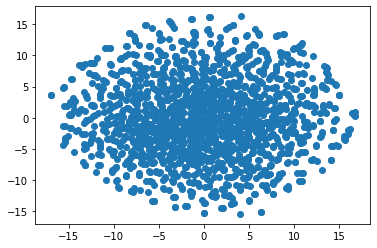

In [14]:
with torch.no_grad():
    df = tsne_movie_embeddings(model)
plt.scatter('x', 'y', data=df)

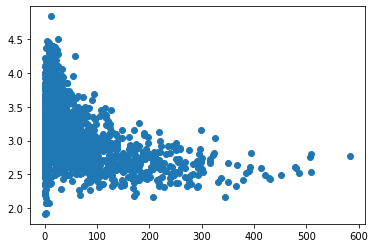

In [15]:
with torch.no_grad():
    df = movie_embedding_norm(model)
plt.scatter('num_ratings', 'norm', data=df)

## With lower std?
Some niche movies (ones with few ratings) have a high norm, leading to spurious recommendations. This can happen if the embedding of that movie happens to be initialized with a high norm. Regularization will alleviate this problem.     
Or, with lower init_std, niche movies will be initialized with a lower norm. The expected norm of a $d$ dimensional vector with entries $~N(0,\sigma ^2)$ is approximatley $\sigma\sqrt{d}$    


In [16]:
embedding_dim = 30
init_std = .05
epoch = 1000
lr = 3e-3

In [17]:
model_lowstd = CFModel(users.shape[0], movies.shape[0], embedding_dim, init_std)
optimizer = torch.optim.Adam(model_lowstd.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

for e in range(epoch):
    # train
    pred = model_lowstd(A_train)
    loss = criterion(pred, A_train.values())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # valid
    with torch.no_grad():
        pred = model_lowstd(A_val)
        val_loss = criterion(pred, A_val.values())
    
    if e % 200 == 199:
        print('---------------')
        print(f'Epoch {e+1}')
        print(f'Train loss: {loss.item()}\nValidation loss: {val_loss.item()}')

---------------
Epoch 200
Train loss: 0.8076143860816956
Validation loss: 0.9002135992050171
---------------
Epoch 400
Train loss: 0.7288114428520203
Validation loss: 0.8845545053482056
---------------
Epoch 600
Train loss: 0.608353316783905
Validation loss: 0.8822706341743469
---------------
Epoch 800
Train loss: 0.47407934069633484
Validation loss: 0.9131853580474854
---------------
Epoch 1000
Train loss: 0.36035987734794617
Validation loss: 0.98594069480896


Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682


C:\Users\yhoon\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\yhoon\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.151448


C:\Users\yhoon\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.883858
[t-SNE] KL divergence after 400 iterations: 2.021442


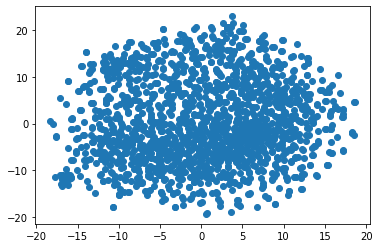

In [18]:
with torch.no_grad():
    df = tsne_movie_embeddings(model_lowstd)
plt.scatter('x', 'y', data=df)

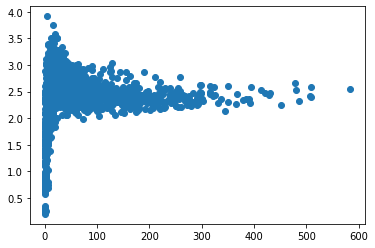

In [19]:
with torch.no_grad():
    df = movie_embedding_norm(model_lowstd)
plt.scatter('num_ratings', 'norm', data=df)

# Regularization in Matrix Factorization
The loss was observed part of the rating matrix. This can be problematic as the model does not learn how to place the embeddings of irrlevant movies. This phenomenon is known as **folding**.      
To address this issue, we can add regularization terms.
- Regularization of the model parameters.($l_2$ norm)     
    $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.
- A global prior that pushes the prediction of any pair towards zero, called the gravity term.     
    $g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$.      
As a result, the total loss is given by    
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$
$\lambda_r$ and $\lambda_g$ are regularization coefficients.

In [23]:
model.user_embedding.weight.shape[0]

943

In [33]:
def reg_loss(pred, target, model, lambda_r, lambda_g):
    loss = torch.nn.functional.mse_loss(pred, target)
    U = model.user_embedding.weight
    V = model.movie_embedding.weight
    r = (U*U).sum() / U.shape[0] + (V*V).sum() / V.shape[0]
    g = torch.sum((U@V.T)**2) / (U.shape[0] * V.shape[0])
    return loss + lambda_r * r + lambda_g * g

In [37]:
embedding_dim = 30
init_std = .05
epoch = 1000
lr = 1e-2
lambda_r = .1
lambda_g = 1.0

In [38]:
from functools import partial

model_reg = CFModel(users.shape[0], movies.shape[0], embedding_dim, init_std)
optimizer = torch.optim.Adam(model_reg.parameters(), lr=lr)
criterion = partial(reg_loss, model=model_reg, lambda_r=lambda_r, lambda_g=lambda_g)

for e in range(epoch):
    # train
    pred = model_reg(A_train)
    loss = criterion(pred, A_train.values())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 200 == 199:
        # valid
        with torch.no_grad():
            pred = model_lowstd(A_val)
            val_loss = criterion(pred, A_val.values())
        print('---------------')
        print(f'Epoch {e+1}')
        print(f'Train loss: {loss.item()}\nValidation loss: {val_loss.item()}')

---------------
Epoch 200
Train loss: 3.5463218688964844
Validation loss: 3.089067220687866
---------------
Epoch 400
Train loss: 3.276435375213623
Validation loss: 3.1314496994018555
---------------
Epoch 600
Train loss: 3.2351431846618652
Validation loss: 3.13671875
---------------
Epoch 800
Train loss: 3.2228341102600098
Validation loss: 3.138339042663574
---------------
Epoch 1000
Train loss: 3.217693567276001
Validation loss: 3.1391139030456543


Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.251326


C:\Users\yhoon\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\yhoon\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
C:\Users\yhoon\Anaconda3\envs\python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.218021
[t-SNE] KL divergence after 400 iterations: 1.439765


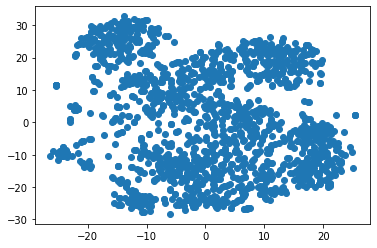

In [41]:
# much more clustered result!
with torch.no_grad():
    df = tsne_movie_embeddings(model_reg)
plt.scatter('x', 'y', data=df)

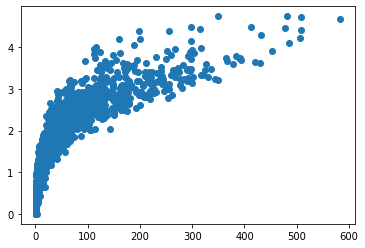

In [42]:
with torch.no_grad():
    df = movie_embedding_norm(model_reg)
plt.scatter('num_ratings', 'norm', data=df)

In [43]:
with torch.no_grad():
    movie_neighbors(model_reg, "Aladdin", 'dot', k=10)
    movie_neighbors(model_reg, "Aladdin", 'cosine', k=10)

Nearest neighbors of : Aladdin
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,dot score,titles,genres
94,8.242240,Aladdin (1992),Animation-Children-Comedy-Musical
70,7.668483,"Lion King, The (1994)",Animation-Children-Musical
173,7.398147,Raiders of the Lost Ark (1981),Action-Adventure
0,7.325230,Toy Story (1995),Animation-Children-Comedy
171,7.320273,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War
27,7.215361,Apollo 13 (1995),Action-Drama-Thriller
587,7.014636,Beauty and the Beast (1991),Animation-Children-Musical
68,6.969608,Forrest Gump (1994),Comedy-Romance-War
172,6.891854,"Princess Bride, The (1987)",Action-Adventure-Comedy-Romance
201,6.831155,Groundhog Day (1993),Comedy-Romance


Nearest neighbors of : Aladdin
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,cosine score,titles,genres
94,1.000000,Aladdin (1992),Animation-Children-Comedy-Musical
70,0.905931,"Lion King, The (1994)",Animation-Children-Musical
587,0.838534,Beauty and the Beast (1991),Animation-Children-Musical
27,0.815667,Apollo 13 (1995),Action-Drama-Thriller
417,0.801682,Cinderella (1950),Animation-Children-Musical
201,0.787844,Groundhog Day (1993),Comedy-Romance
98,0.786793,Snow White and the Seven Dwarfs (1937),Animation-Children-Musical
418,0.784552,Mary Poppins (1964),Children-Comedy-Musical
81,0.769861,Jurassic Park (1993),Action-Adventure-Sci-Fi
142,0.749912,"Sound of Music, The (1965)",Musical


### Conclusion
This concludes this section on matrix factorization models. Note that while the scale of the problem is small enough to allow efficient training using SGD, many practical problems need to be trained using more specialized algorithms such as Alternating Least Squares 